# Rapid tone-pip sequences

Here we attempt to recreate the auditory stimuli used in [Bianco et al. (2020)](https://doi.org/10.7554/eLife.56073).

Read the abstract, and check out [Figure 1](https://elifesciences.org/articles/56073#fig1).

We will recreate the RAN and RANREG sequences here. 

---

In [2]:
from thebeat.core import Sequence, Stimulus, StimSequence
import numpy as np

rng = np.random.default_rng(seed=123)

In [3]:
# We suppress warnings, but let's hide that to avoid confusion
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Creating the RAN sequence

These sequences were random sequences with a number of properties:

* The **sequences** were isochronous, had 140 events (i.e. total duration was 7 seconds), and had an inter-onset interval (IOI) of 50 ms.
* The **sounds** had a duration equal to the IOI of 50 ms, so there was no silence in between the sounds.
* The sounds themselves were tone-pips of different frequencies. The frequencies were randomly sampled from twenty values logarithmically spaced between 222 Hz and 2000 Hz.
* An additional constraint was that no two the same frequencies could occur consecutively, which is why we use the ``while`` loop that keeps on sampling if the newly chosen frequency was the same as the last one in the list of already-sampled frequencies.

In [4]:
# Sample the sounds' frequencies with the constraint that no 
# two the same frequencies can occur consecutively.

freqs = np.geomspace(222, 2000, 20)

freqs_sample = [rng.choice(freqs)]

for _ in range(139):  # sample the other 139 tone freqs
    choice = rng.choice(freqs)
    while choice == freqs_sample[-1]: 
        choice = rng.choice(freqs)
    freqs_sample.append(choice) 

In [5]:
# Create the sequence
seq = Sequence.generate_isochronous(n=140, ioi=50)

# Create the sounds
stims = [Stimulus.generate(freq=freq, 
                           duration_ms=50, 
                           onramp_ms=5, 
                           offramp_ms=5, 
                           ramp_type='raised-cosine') for freq in freqs_sample]

# Make the trial
RAN_trial = StimSequence(stims, seq, name="RAN sequence")

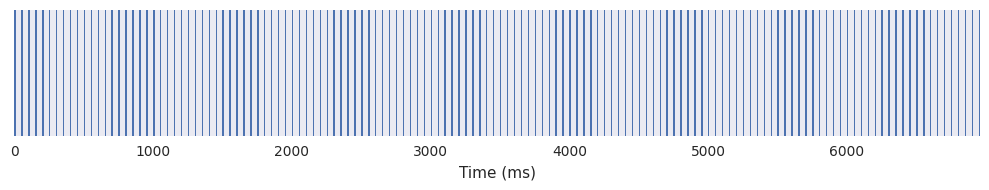

In [6]:
RAN_trial.plot_sequence(linewidth=10, figsize=(10, 2));
# RAN_trial.write_wav('example_RAN.wav')

In [7]:
# This is only so you can listen to the sound here. On your computer, simply execute RAN_trial.play()
from IPython.display import Audio
Audio(RAN_trial.samples, rate=RAN_trial.fs)

## Creating the RAN_REG sequence
From a random point in the sequence, we start cycling a shorter sequence.

* At a random point between 3000 and 4000 ms the sequences suddenly becomes regular
* A cycle of 20 frequencies is then repeated until the end of the sequence


### Creating the regular cycle frequencies

In [9]:
# Freqs for the regular cycle
freqs = np.geomspace(222, 2000, 20)
cycle_freqs = [rng.choice(freqs)]

for _ in range(19):
    choice = rng.choice(freqs)
    while choice == freqs_sample[-1]:
        choice = rng.choice(freqs)
    cycle_freqs.append(choice)

change_event_index = int(rng.choice(np.arange(3000/50, 4000/50)))
random_bit = freqs_sample[:change_event_index]
ran_reg = random_bit + cycle_freqs * 4  # combine random bit and 4 cycles (which will be enough)
ran_reg = ran_reg[:140] # Trim to 140 events

### Combing the random part with the regular cycle

It will be easiest to start doing that from a certain event, rather than millisecond, so let's assume we can choose an index where it starts.

In [10]:
change_event_index = int(rng.choice(np.arange(3000/50, 4000/50)))
random_bit = freqs_sample[:change_event_index]
ran_reg = random_bit + cycle_freqs * 4  # combine random bit and 4 cycles (which will be enough)
ran_reg = ran_reg[:140] # Trim to 140 events

### Combine them into a StimSequence

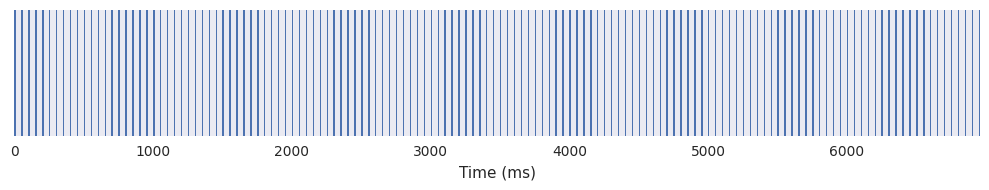

In [11]:
# Create the sequence
seq = Sequence.generate_isochronous(n=140, ioi=50)

# Create the sounds
stims = [Stimulus.generate(freq=freq, 
                           duration_ms=50, 
                           onramp_ms=5, 
                           offramp_ms=5, 
                           ramp_type='raised-cosine') for freq in ran_reg]

# Make the trial
RANREG_trial = StimSequence(stims, seq, name="RANREG sequence")

# Plot it
RANREG_trial.plot_sequence(linewidth=10, figsize=(10, 2));

In [12]:
# This is only so you can listen to the sound here. On your computer, simply execute RAN_trial.play()
from IPython.display import Audio
Audio(RANREG_trial.samples, rate=RANREG_trial.fs)

## Bonus: Plotting spectograms using Parselmouth

### RAN sequence

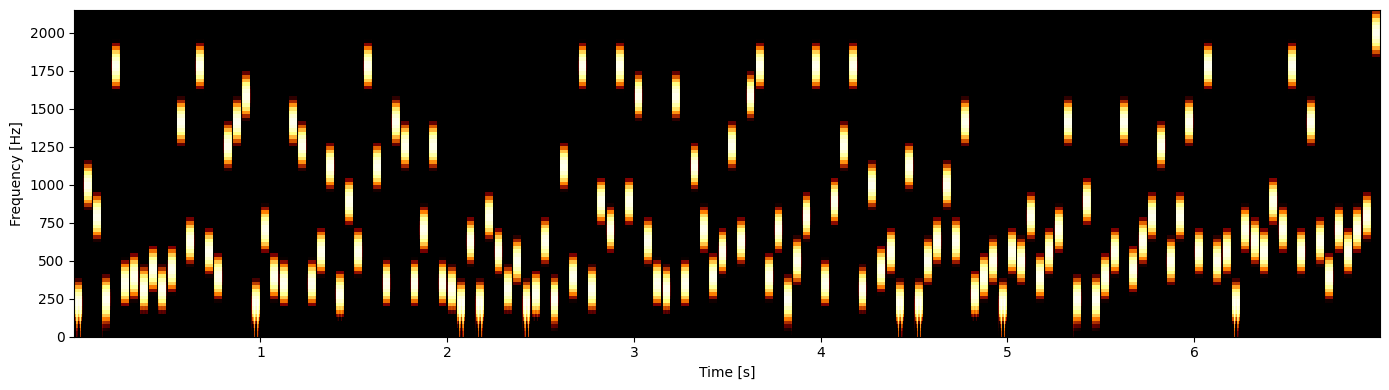

In [13]:
import parselmouth
import matplotlib.pyplot as plt

# For making spectogram
def draw_spectrogram(spectrogram, dynamic_range=5):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    fig, ax = plt.subplots(figsize=(14, 4), tight_layout=True)
    ax.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    ax.axes.set_ylim([spectrogram.ymin, 2150])
    ax.axes.set_xlabel("Time [s]")
    ax.axes.set_ylabel("Frequency [Hz]")

    return fig, ax

    
parselmouth_sound = parselmouth.Sound(values=RAN_trial.samples, sampling_frequency=RAN_trial.fs)
spectogram = parselmouth_sound.to_spectrogram()

fig, ax = draw_spectrogram(spectogram)
fig.savefig('spectogram.png', dpi=600)

### RANREG sequence

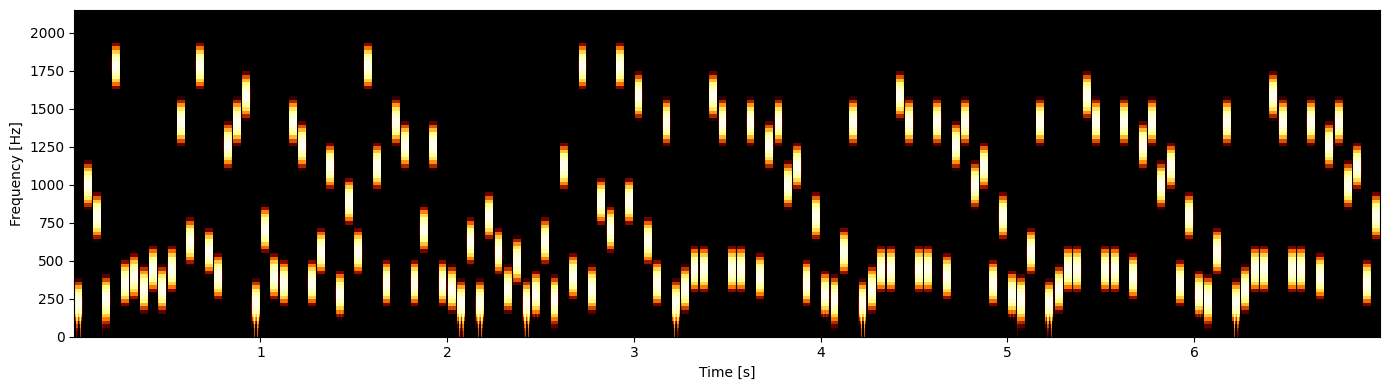

In [14]:
parselmouth_sound = parselmouth.Sound(values=RANREG_trial.samples, sampling_frequency=RANREG_trial.fs)
spectogram = parselmouth_sound.to_spectrogram()

fig, ax = draw_spectrogram(spectogram)
fig.savefig('ranreg.png', dpi=600)